# Dinitz算法及其应用

在本教程中，我们将探讨最大流问题 [^1] 和 Dinitz 算法 [^2]，该算法在 NetworkX 中的
[`algorithms/flow/dinitz_alg.py`](https://github.com/networkx/networkx/blob/main/networkx/algorithms/flow/dinitz_alg.py)
实现。我们还将了解如何使用它来解决一些有趣的问题。

## 导入包

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
from copy import deepcopy
from collections import deque

## 最大流问题

### 动机

假设你想尽快将一些数据发送给你的朋友，但你们之间唯一的通信/数据传输方式是通过一个点对点网络。这个点对点网络的一个有趣之处在于，它允许你沿着指定的路径发送数据，并且每对节点之间每秒可以发送的数据大小有特定的限制。

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20320 (\N{CJK UNIFIED IDEOGRAPH-4F60}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26379 (\N{CJK UNIFIED IDEOGRAPH-670B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21451 (\N{CJK UNIFIED IDEOGRAPH-53CB}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20320 (\N{CJK UNIFIED IDEOGRAPH-4F60}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26379 (\N{CJK UNIFIED IDEOGRAPH-670B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages

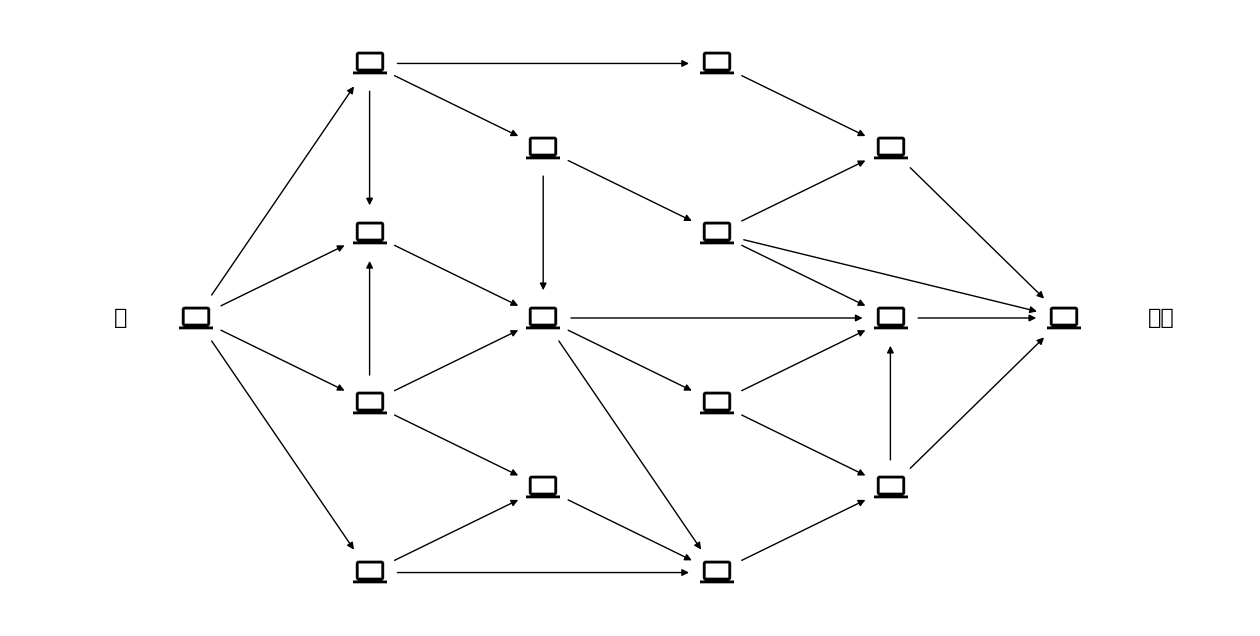

In [2]:
G = nx.read_gml("data/example_graph.gml")

# 从图中提取节点位置信息（用于可视化）
pos = {k: np.asarray(v) for k, v in G.nodes(data="pos")}
label_pos = deepcopy(pos)
label_pos["s"][0] = -1.15
label_pos["t"][0] = 1.20
labels = {"s": "你", "t": "朋友"}

fig, ax = plt.subplots(figsize=(16, 8))
nx.draw_networkx_edges(G, pos=pos, ax=ax, min_source_margin=20, min_target_margin=20)
nx.draw_networkx_labels(G, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4])
ax.axis("off")

# 用计算机图标装饰图像以表示节点
tr_figure = ax.transData.transform
tr_axes = fig.transFigure.inverted().transform
icon_size = abs(np.diff(ax.get_xlim())) * 0.015
icon_center = icon_size / 2
icon = PIL.Image.open("images/computer_black_144x144.png")
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(icon)
    a.axis("off")

那么，你应该如何规划数据包的路径，以最短的时间发送它们呢？

请注意，在这里我们可以将数据分成小的数据包，并通过网络发送，接收方可以重新排列数据包以重建原始数据。

### 形式化
那么，我们如何用图论来建模这个问题呢？

假设 $N=(V, E)$ 表示这个点对点网络，其中 $V$ 是节点集合（计算机），$E$ 是边集合，边 $uv \in E$ 表示节点 $u$ 和节点 $v$ 之间有连接，可以通过该连接发送数据。还有两个特殊节点，第一个是你（节点 $s$），第二个是你的朋友（节点 $t$）。我们分别称它们为 ***源*** 和 ***汇*** 节点。

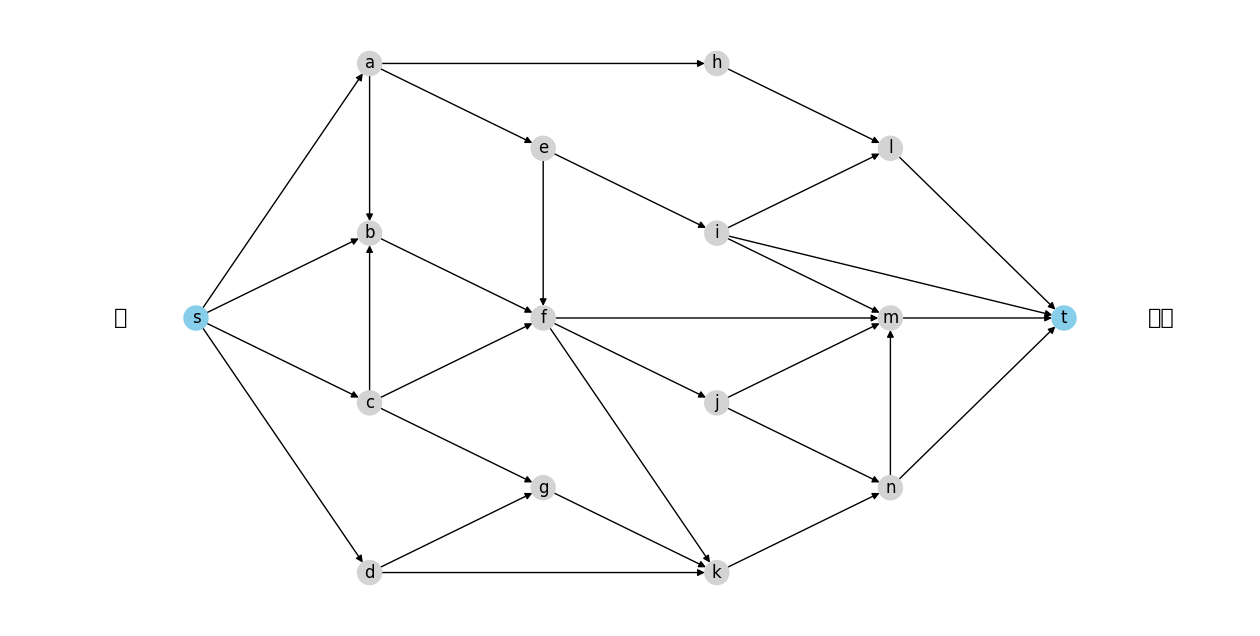

In [3]:
fig, ax = plt.subplots(figsize=(16, 8))

# 为源节点和汇节点着色
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in G.nodes]

# 绘制图
nx.draw(G, pos, ax=ax, node_color=node_colors, with_labels=True)
nx.draw_networkx_labels(G, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4]);

现在假设节点 $u$ 和节点 $v$ 相连，每秒从节点 $u$ 发送到节点 $v$ 的最大数据量是 $c_{uv}$，我们称这个为边 $uv$ 的容量。

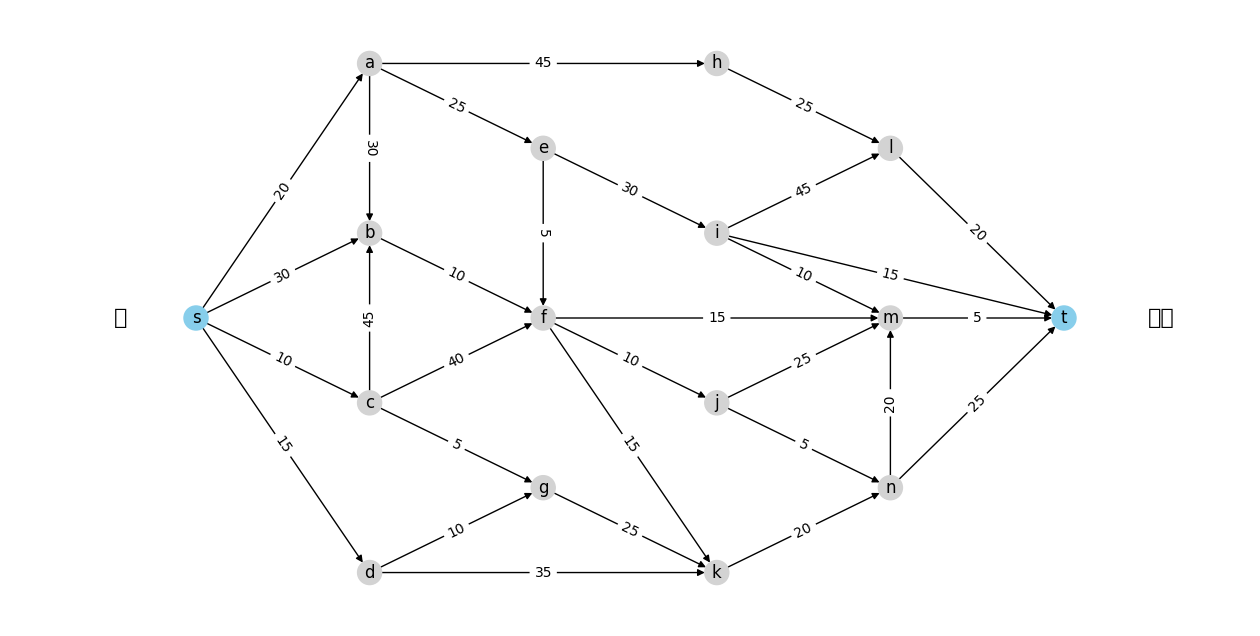

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))

# 标记容量
capacities = {(u, v): c for u, v, c in G.edges(data="capacity")}

# 绘制图
nx.draw(G, pos, ax=ax, node_color=node_colors, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=capacities, ax=ax)
nx.draw_networkx_labels(G, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4]);

因此，在我们继续规划发送数据包的路径之前，我们需要一些方法来表示或规划网络。观察到任何计划都必须占用边的某些容量，因此我们可以用每个边被占用的容量值来表示计划，我们称这个计划为 **流**。形式上，我们可以将流定义为 $f: E \to \mathbb{R}$，即从边 $E$ 到实数的映射，表示我们通过边 $uv \in E$ 以 $f(uv)$ 的速率发送数据。

请注意，为了使这个计划有效，它必须满足以下约束条件：
* **容量约束：**
    从任何节点发送数据的速率不应超过其容量，形式上 $f_{uv} \le c_{uv}$
* **流量守恒：**
    数据发送至节点的速率与节点发送数据至其他节点的速率相同，除了源节点 $s$ 和汇节点 $t$ 之外。形式上，对于 $v \in V \backslash \{s, t\}$，有 $\sum\limits_{u|(u,v) \in E}f_{u,v} = \sum\limits_{w|(v,w) \in E}f_{v,w}$。

In [5]:
def check_valid_flow(G, flow, source_node, target_node):
    H = nx.DiGraph()
    H.add_edges_from(flow.keys())

    for (u, v), f in flow.items():
        capacity = G[u][v]["capacity"]
        H[u][v]["label"] = f"{f}/{capacity}"
        # 容量约束
        if f > G[u][v]["capacity"]:
            H[u][v]["edgecolor"] = "red"
            print(f"无效流量：容量约束在边 ({u!r}, {v!r}) 上被违反")
        # 流量守恒
        if v not in {source_node, target_node}:
            incoming_flow = sum(
                flow[(i, v)] if (i, v) in flow else 0 for i in G.predecessors(v)
            )
            outgoing_flow = sum(
                flow[(v, o)] if (v, o) in flow else 0 for o in G.successors(v)
            )
            if not math.isclose(incoming_flow, outgoing_flow):
                print(f"无效流量：流量守恒在节点 {v} 上被违反")
                H.nodes[v]["color"] = "red"
    return H


def visualize_flow(flow_graph):
    """可视化由 `check_valid_flow` 函数返回的流量。"""
    fig, ax = plt.subplots(figsize=(15, 9))

    # 绘制参考完整图
    nx.draw(
        G, pos, ax=ax, node_color=node_colors, edge_color="lightgrey", with_labels=True
    )

    # 在顶部绘制示例流量
    flow_nc = [
        "skyblue" if n in {"s", "t"} else flow_graph.nodes[n].get("color", "lightgrey")
        for n in flow_graph
    ]
    flow_ec = [flow_graph[u][v].get("edgecolor", "black") for u, v in flow_graph.edges]
    edge_labels = {(u, v): lbl for u, v, lbl in flow_graph.edges(data="label")}
    nx.draw(flow_graph, pos, ax=ax, node_color=flow_nc, edge_color=flow_ec)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax);

有效流量的示例：

In [6]:
example_flow = {
    ("s", "a"): 20,
    ("a", "e"): 15,
    ("e", "i"): 15,
    ("i", "t"): 15,
    ("a", "h"): 5,
    ("h", "l"): 5,
    ("l", "t"): 5,
}

flow_graph = check_valid_flow(G, example_flow, "s", "t")

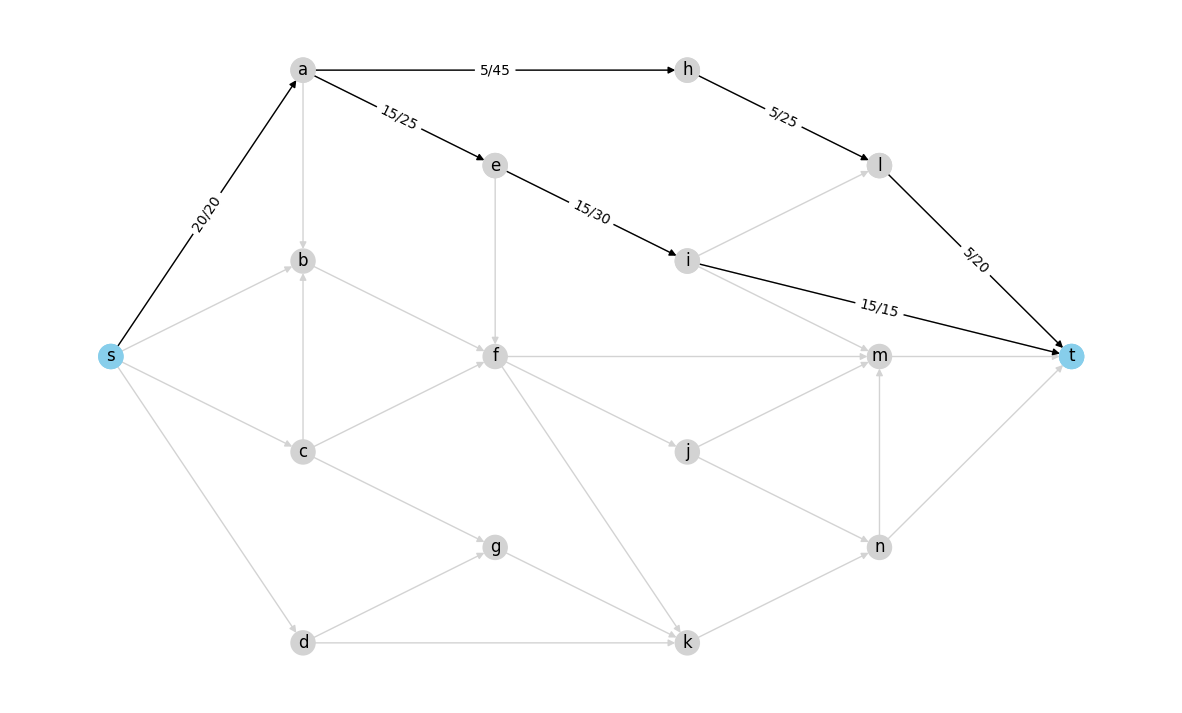

In [7]:
visualize_flow(flow_graph)

无效流量的示例：

In [8]:
example_flow = {
    ("s", "a"): 30,
    ("a", "e"): 25,
    ("e", "i"): 15,
    ("i", "t"): 15,
    ("a", "h"): 5,
    ("h", "l"): 5,
    ("l", "t"): 5,
}

flow_graph = check_valid_flow(G, example_flow, "s", "t")

无效流量：容量约束在边 ('s', 'a') 上被违反
无效流量：流量守恒在节点 e 上被违反


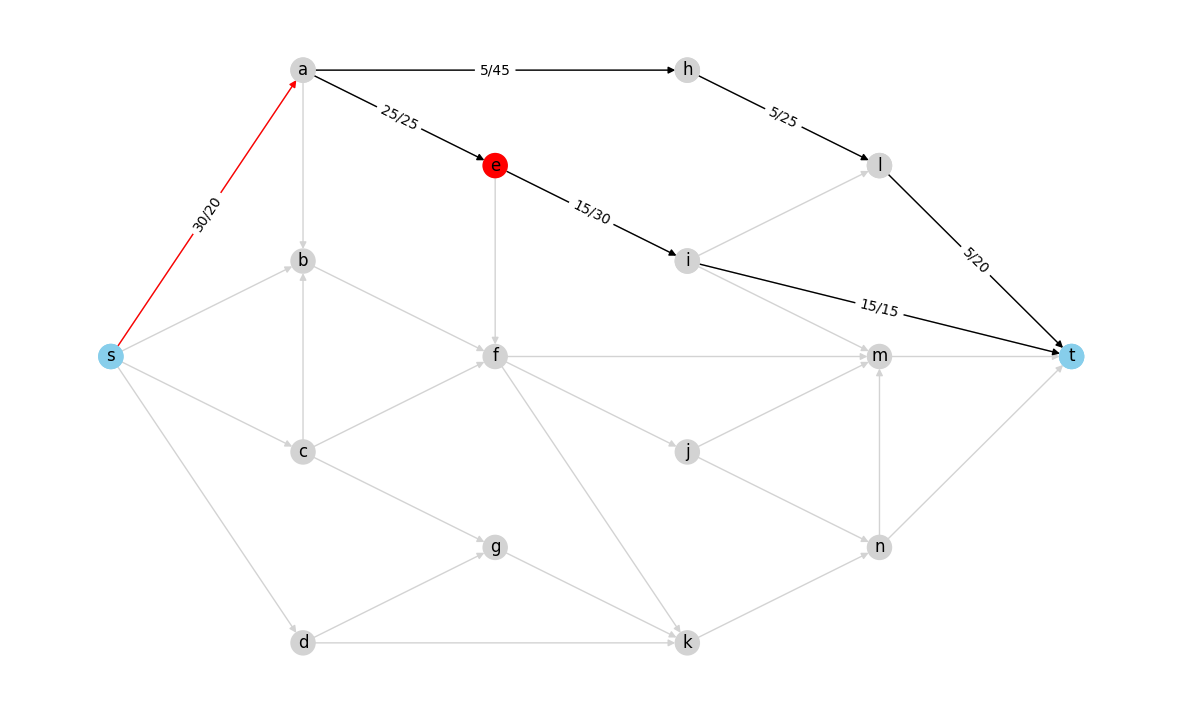

In [9]:
visualize_flow(flow_graph)

红色边不满足容量约束，红色节点不满足流量守恒。

*如果我们使用这个计划/流量来发送数据，那么我们将以什么速率向朋友发送数据？*

为了回答这个问题，我们需要注意到汇节点 $t$ 接收的任何数据都将来自其邻居，因此如果我们从这些邻居到汇节点的计划/流量中求和数据速率，我们将得到 $t$ 接收数据的总速率。形式上，我们可以称流量的**值**为 $|f|=\sum\limits_{u|(u,t) \in E}f_{u,t}$。还要注意，由于流量是守恒的，$|f|$ 也将等于 $\sum\limits_{u|(s,u) \in E}f_{s,u}$。

记住我们的目标是最大化发送给朋友的数据速率，这等同于最大化流量值 $|f|$。

这就是**最大流问题**的定义。

## Dinitz 算法

在理解 Dinitz 算法的工作原理及其步骤之前，让我们先定义一些术语。

### 剩余容量与图
如果我们通过容量为 $c_{uv}$ 的边 $uv$ 发送 $f_{uv}$ 流量，那么我们通过 $g_{uv}=c_{uv}-f_{uv}$ 定义剩余容量，并通过 $N'$ 定义剩余网络，它只考虑 $N$ 中具有非零剩余容量的边。

In [10]:
def residual_graph(G, flow):
    H = G.copy()
    for (u, v), f in flow.items():
        capacity = G[u][v]["capacity"]
        if f > G[u][v]["capacity"]:
            raise ValueError(f"流量 {f} 超过了边 {u!r}->{v!r} 的容量。")
        H[u][v]["capacity"] -= f
        if H.has_edge(v, u):
            H[v][u]["capacity"] += f
        else:
            H.add_edge(v, u, capacity=f, etype="rev")
    return H


def draw_residual_graph(R, ax=None):
    """可视化由 `residual_graph` 返回的残余图。"""
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 9))
        ax.axis("off")

    # 绘制节点
    nx.draw_networkx_nodes(R, pos, node_color=node_colors)
    nx.draw_networkx_labels(R, pos)

    # 根据容量和是否由 residual_graph 添加对边进行分类
    orig_edges, zero_edges, rev_edges = [], [], []
    for u, v, data in R.edges(data=True):
        if data.get("etype") == "rev":
            rev_edges.append((u, v))
        elif data["capacity"] == 0:
            zero_edges.append((u, v))
        else:
            orig_edges.append((u, v))

    # 绘制边
    nx.draw_networkx_edges(R, pos, edgelist=orig_edges)
    nx.draw_networkx_edges(
        R,
        pos,
        edgelist=rev_edges,
        edge_color="goldenrod",
        connectionstyle="arc3,rad=0.2",
    )
    nx.draw_networkx_edges(
        R, pos, edgelist=zero_edges, style="--", edge_color="lightgrey"
    )

    # 用容量标记边
    rv = set(rev_edges)
    fwd_caps = {(u, v): c for u, v, c in R.edges(data="capacity") if (u, v) not in rv}
    rev_caps = {(u, v): c for u, v, c in R.edges(data="capacity") if (u, v) in rv}
    nx.draw_networkx_edge_labels(R, pos, edge_labels=fwd_caps, label_pos=0.667)
    nx.draw_networkx_edge_labels(
        R, pos, edge_labels=rev_caps, label_pos=0.667, font_color="goldenrod"
    )

示例流程：

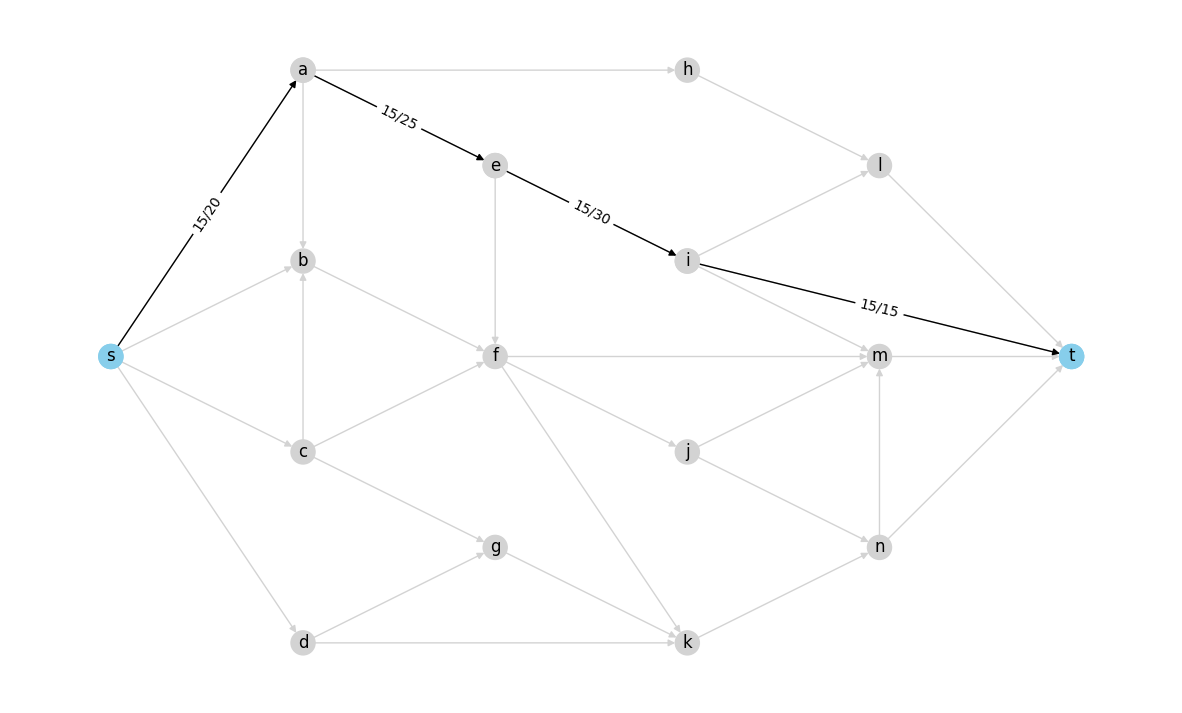

In [11]:
example_flow = {
    ("s", "a"): 15,
    ("a", "e"): 15,
    ("e", "i"): 15,
    ("i", "t"): 15,
}

visualize_flow(check_valid_flow(G, example_flow, "s", "t"))

这是上述流对应的残余网络：

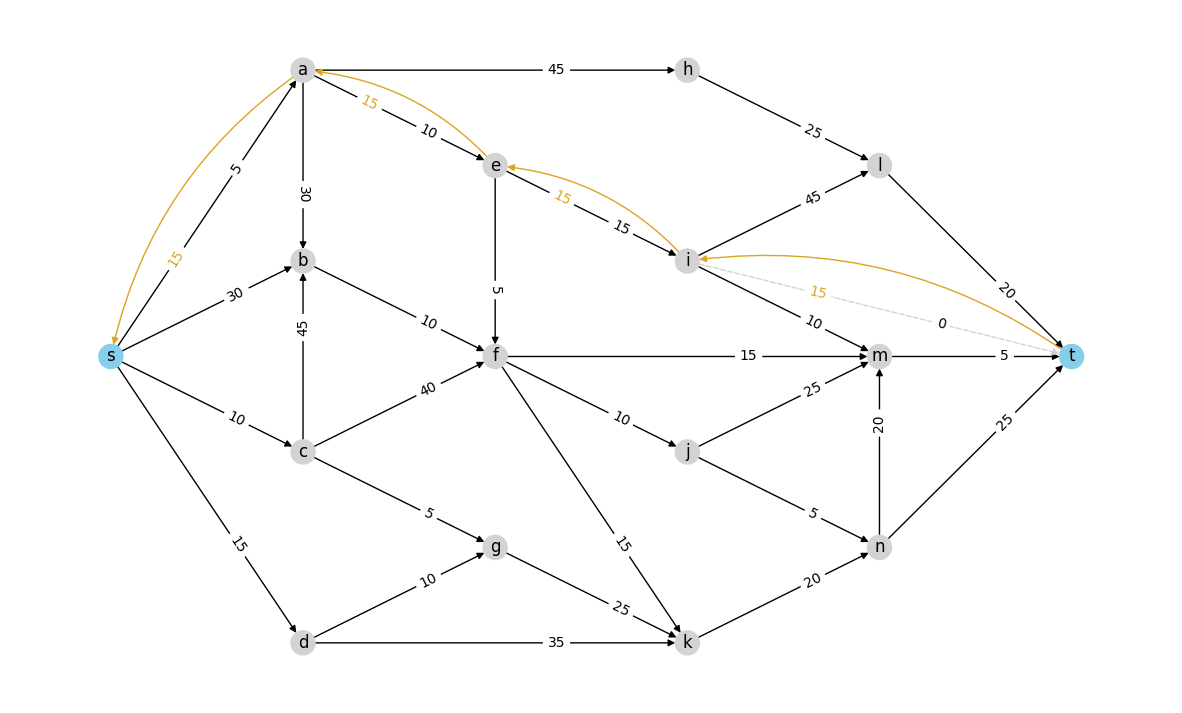

In [12]:
R = residual_graph(G, example_flow)
draw_residual_graph(R)

注意：在残余网络中，如果 $N$ 中存在 $uv$ 或 $vu$ 边，我们同时考虑这两条边。

### 层次网络

层次网络是残余网络的子图，当我们从源节点 $s$ 应用[广度优先搜索（BFS）](https://en.wikipedia.org/wiki/Breadth-first_search)时，只考虑残余网络中满足 $c_{uv}-f_{uv}>0$ 的边，并将节点分成不同层次，然后只考虑连接两个不同层次节点的边构成的层次网络 $L$。

In [13]:
# 节点层次与颜色的映射，用于可视化
level_colors = {
    1: "aqua",
    2: "lightgreen",
    3: "yellow",
    4: "orange",
    5: "lightpink",
    6: "violet",
}


def level_bfs(R, flow, source_node, target_node):
    """从残余网络构建给定流的层次网络的 BFS 算法。"""
    parents, level = {}, {}
    queue = deque([source_node])
    level[source_node] = 0
    while queue:
        if target_node in parents:
            break
        u = queue.popleft()
        for v in R.successors(u):
            if (v not in parents) and (R[u][v]["capacity"] > 0):
                parents[v] = u
                level[v] = level[u] + 1
                queue.append(v)
    return parents, level


def draw_level_network(R, parents, level, background=False):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")

    # 绘制节点
    nodelist = list(level.keys())
    if background:
        level_nc = "lightgrey"
    else:
        level_nc = [level_colors[l] for l in level.values()]
        level_nc[0] = level_nc[-1] = "skyblue"
    nx.draw_networkx_nodes(R, pos, nodelist=nodelist, node_color=level_nc)
    if not background:
        nx.draw_networkx_labels(R, pos)

    # 绘制边
    fwd_edges = [(v, u) for u, v in parents.items() if (v, u) in G.edges]
    labels = {(u, v): R[u][v]["capacity"] for u, v in fwd_edges}
    ec = "lightgrey" if background else "black"
    nx.draw_networkx_edges(R, pos, edgelist=fwd_edges, edge_color=ec)
    if not background:
        nx.draw_networkx_edge_labels(R, pos, edge_labels=labels, label_pos=0.667)

    rev_edges = [(v, u) for u, v in parents.items() if (v, u) not in G.edges]
    labels = {(u, v): R[u][v]["capacity"] for u, v in rev_edges}
    ec = "lightgrey" if background else "goldenrod"
    nx.draw_networkx_edges(
        R, pos, edgelist=rev_edges, connectionstyle="arc3,rad=0.2", edge_color=ec
    )
    if not background:
        nx.draw_networkx_edge_labels(
            R, pos, edge_labels=labels, label_pos=0.667, font_color="goldenrod"
        )

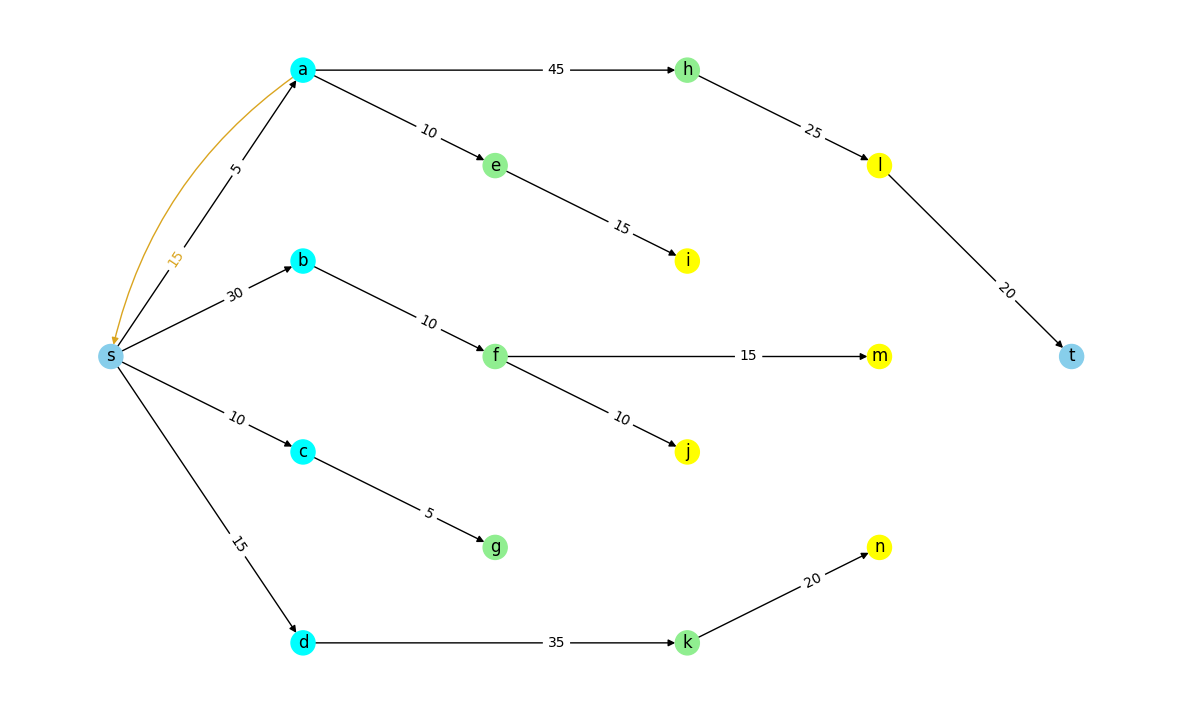

In [14]:
parents, level = level_bfs(R, example_flow, "s", "t")
draw_level_network(R, parents, level)

注意，如果汇节点 $t$ 无法从源节点 $s$ 到达，这意味着无法再通过残余网络推送更多流量。

### 增广路径与流量

*增广路径* $P$ 是从源节点 $s$ 到汇节点 $t$ 的路径，路径上的所有边都具有正的残余容量，即 $g_{uv}>0$ 对于 $uv \in P$。*增广流量* $\alpha$ 是路径 $P$ 上所有边残余流量的最小值，即 $\alpha = min\{g_{uv}, uv \in P\}$。

通过沿路径 $P$ 增广流量，意味着减少路径 $P$ 上各边的残余容量 $\alpha$，这将使得残余网络上至少有一条边的残余容量变为零。

我们通过在层次网络 $L$ 上应用[深度优先搜索（DFS）](https://en.wikipedia.org/wiki/Depth-first_search)来寻找增广路径。

In [15]:
def aug_path_dfs(parents, flow, source_node, target_node):
    """从 target_node 开始使用 DFS 构建路径"""
    path = []
    u = target_node
    f = 3 * max(flow.values())  # 初始化流量为较大值
    while u != source_node:
        path.append(u)
        v = parents[u]
        f = min(f, R.pred[u][v]["capacity"] - flow.get((u, v), 0))
        u = v
    path.append(source_node)
    # 沿找到的路径增广流量
    return path, f

增广前的增广路径：

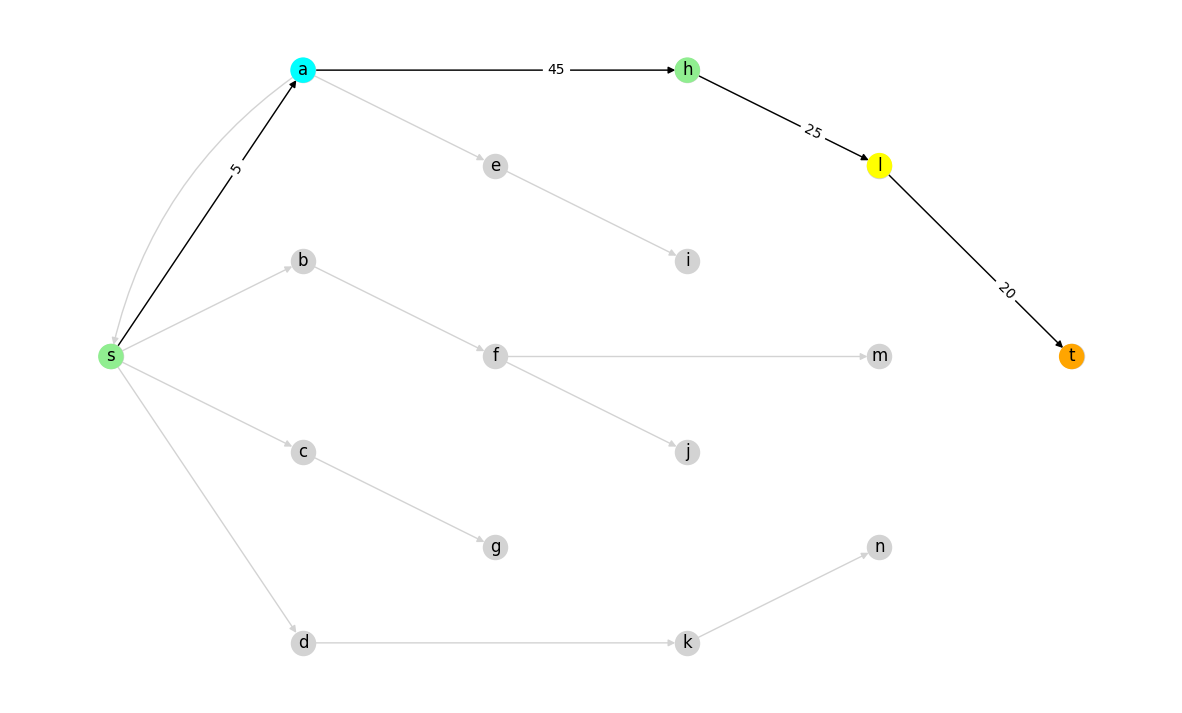

In [16]:
path, min_resid_flow = aug_path_dfs(parents, example_flow, "s", "t")

# 可视化
draw_level_network(R, parents, level, background=True)  # 背景中的层次图
nc = [level_colors[level[n]] for n in path]
el = [(v, u) for u, v in nx.utils.pairwise(path)]
nx.draw(R, pos, nodelist=path, edgelist=el, node_color=nc, with_labels=True)
edgelabels = {(u, v): R[u][v]["capacity"] for u, v in el}
nx.draw_networkx_edge_labels(R, pos, edge_labels=edgelabels, label_pos=0.667);

增广后的增广路径：

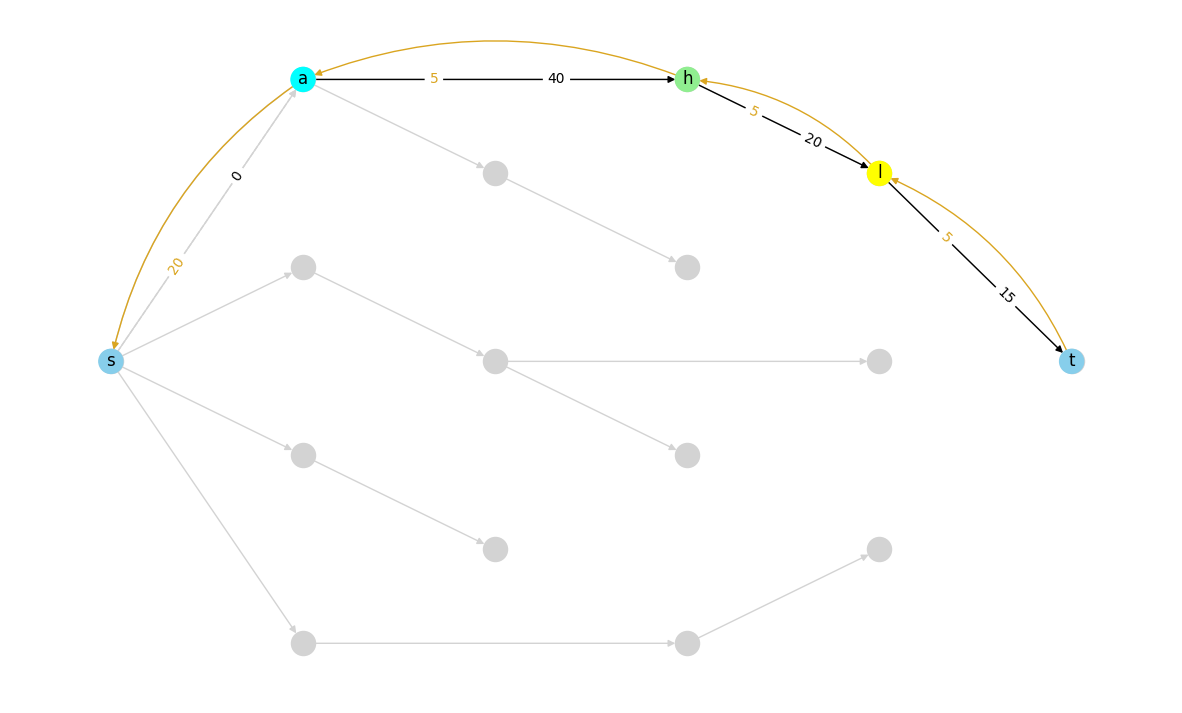

In [17]:
# 沿增广路径应用最小流量
aug_flow = {(v, u): min_resid_flow for u, v in nx.utils.pairwise(path)}

# 可视化沿路径的增广流量
draw_level_network(R, parents, level, background=True)
aug_path = residual_graph(R.subgraph(path), aug_flow)

# 子图中的节点顺序可能与 `path` 不同
nodes = list(aug_path.nodes)
node_colors = [level_colors[level[n]] for n in nodes]
node_colors[nodes.index("s")] = node_colors[nodes.index("t")] = "skyblue"

draw_residual_graph(aug_path, ax=plt.gca())

生成的新的残差网络：

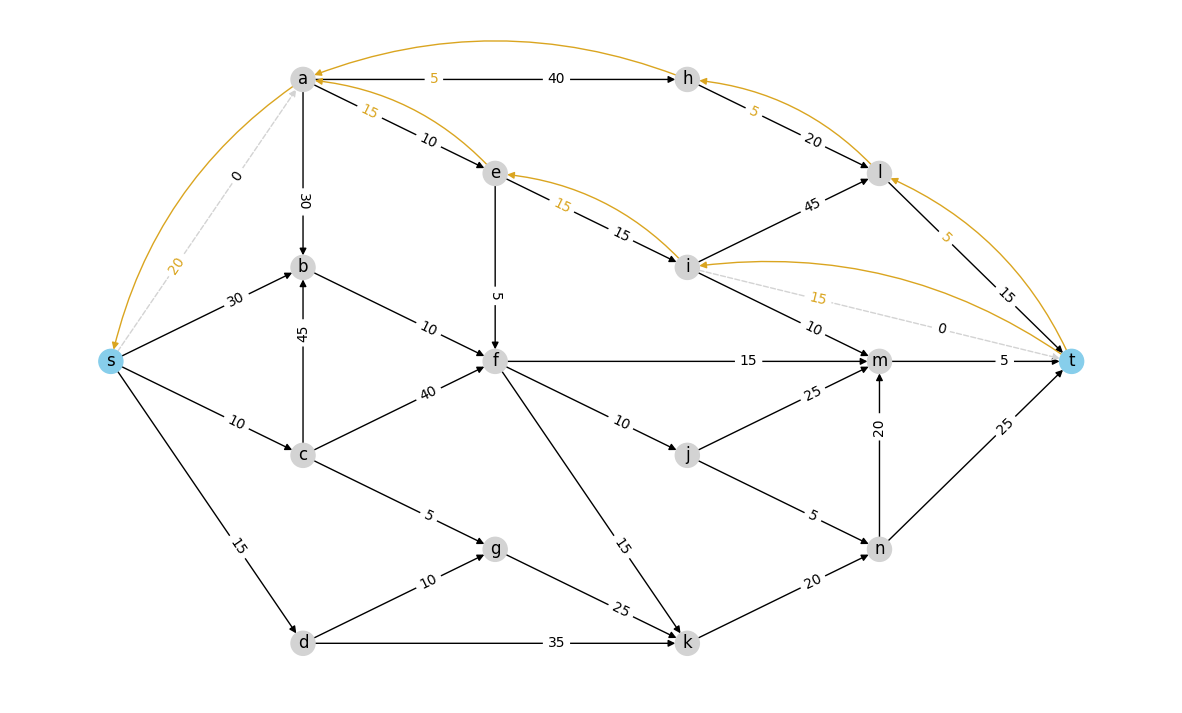

In [18]:
R = residual_graph(R, aug_flow)

# 残差图的原始颜色方案
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in R.nodes]
draw_residual_graph(R)

上述每个步骤在 Dinitz 算法中都扮演着重要角色，用于在网络中寻找最大流，总结如下。

### 算法

1. 初始化一个零值的流，$f_{uv}=0$
2. 根据该流构建一个残差网络 $N'$
3. 使用 BFS 查找层次网络 $L$，如果 $t$ 不在层次网络中则中断并输出该流
4. 在层次网络 $L$ 中找到一条增广路径 $P$
5. 沿着路径 $P$ 的边增广流，这将得到一个新的残差网络
6. 使用新的残差网络 $N'$ 重复步骤 3

## 在 NetworkX 中寻找最大流

在上一节中，我们将 Dinitz 算法分解为更小的步骤，以便更好地理解整个算法。然而在实践中，无需自己实现所有这些步骤！NetworkX 提供了 Dinitz 算法的实现：[nx.flow.dinitz](https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.flow.dinitz.html)。`nx.flow.dinitz` 除了上述描述的功能外，还包括其他几个特性。例如，`cutoff` 关键字参数可用于在达到所需流值时提前终止 Dinitz 算法。

让我们在我们的示例网络 `G` 上尝试 NetworkX 的 Dinitz 算法实现。

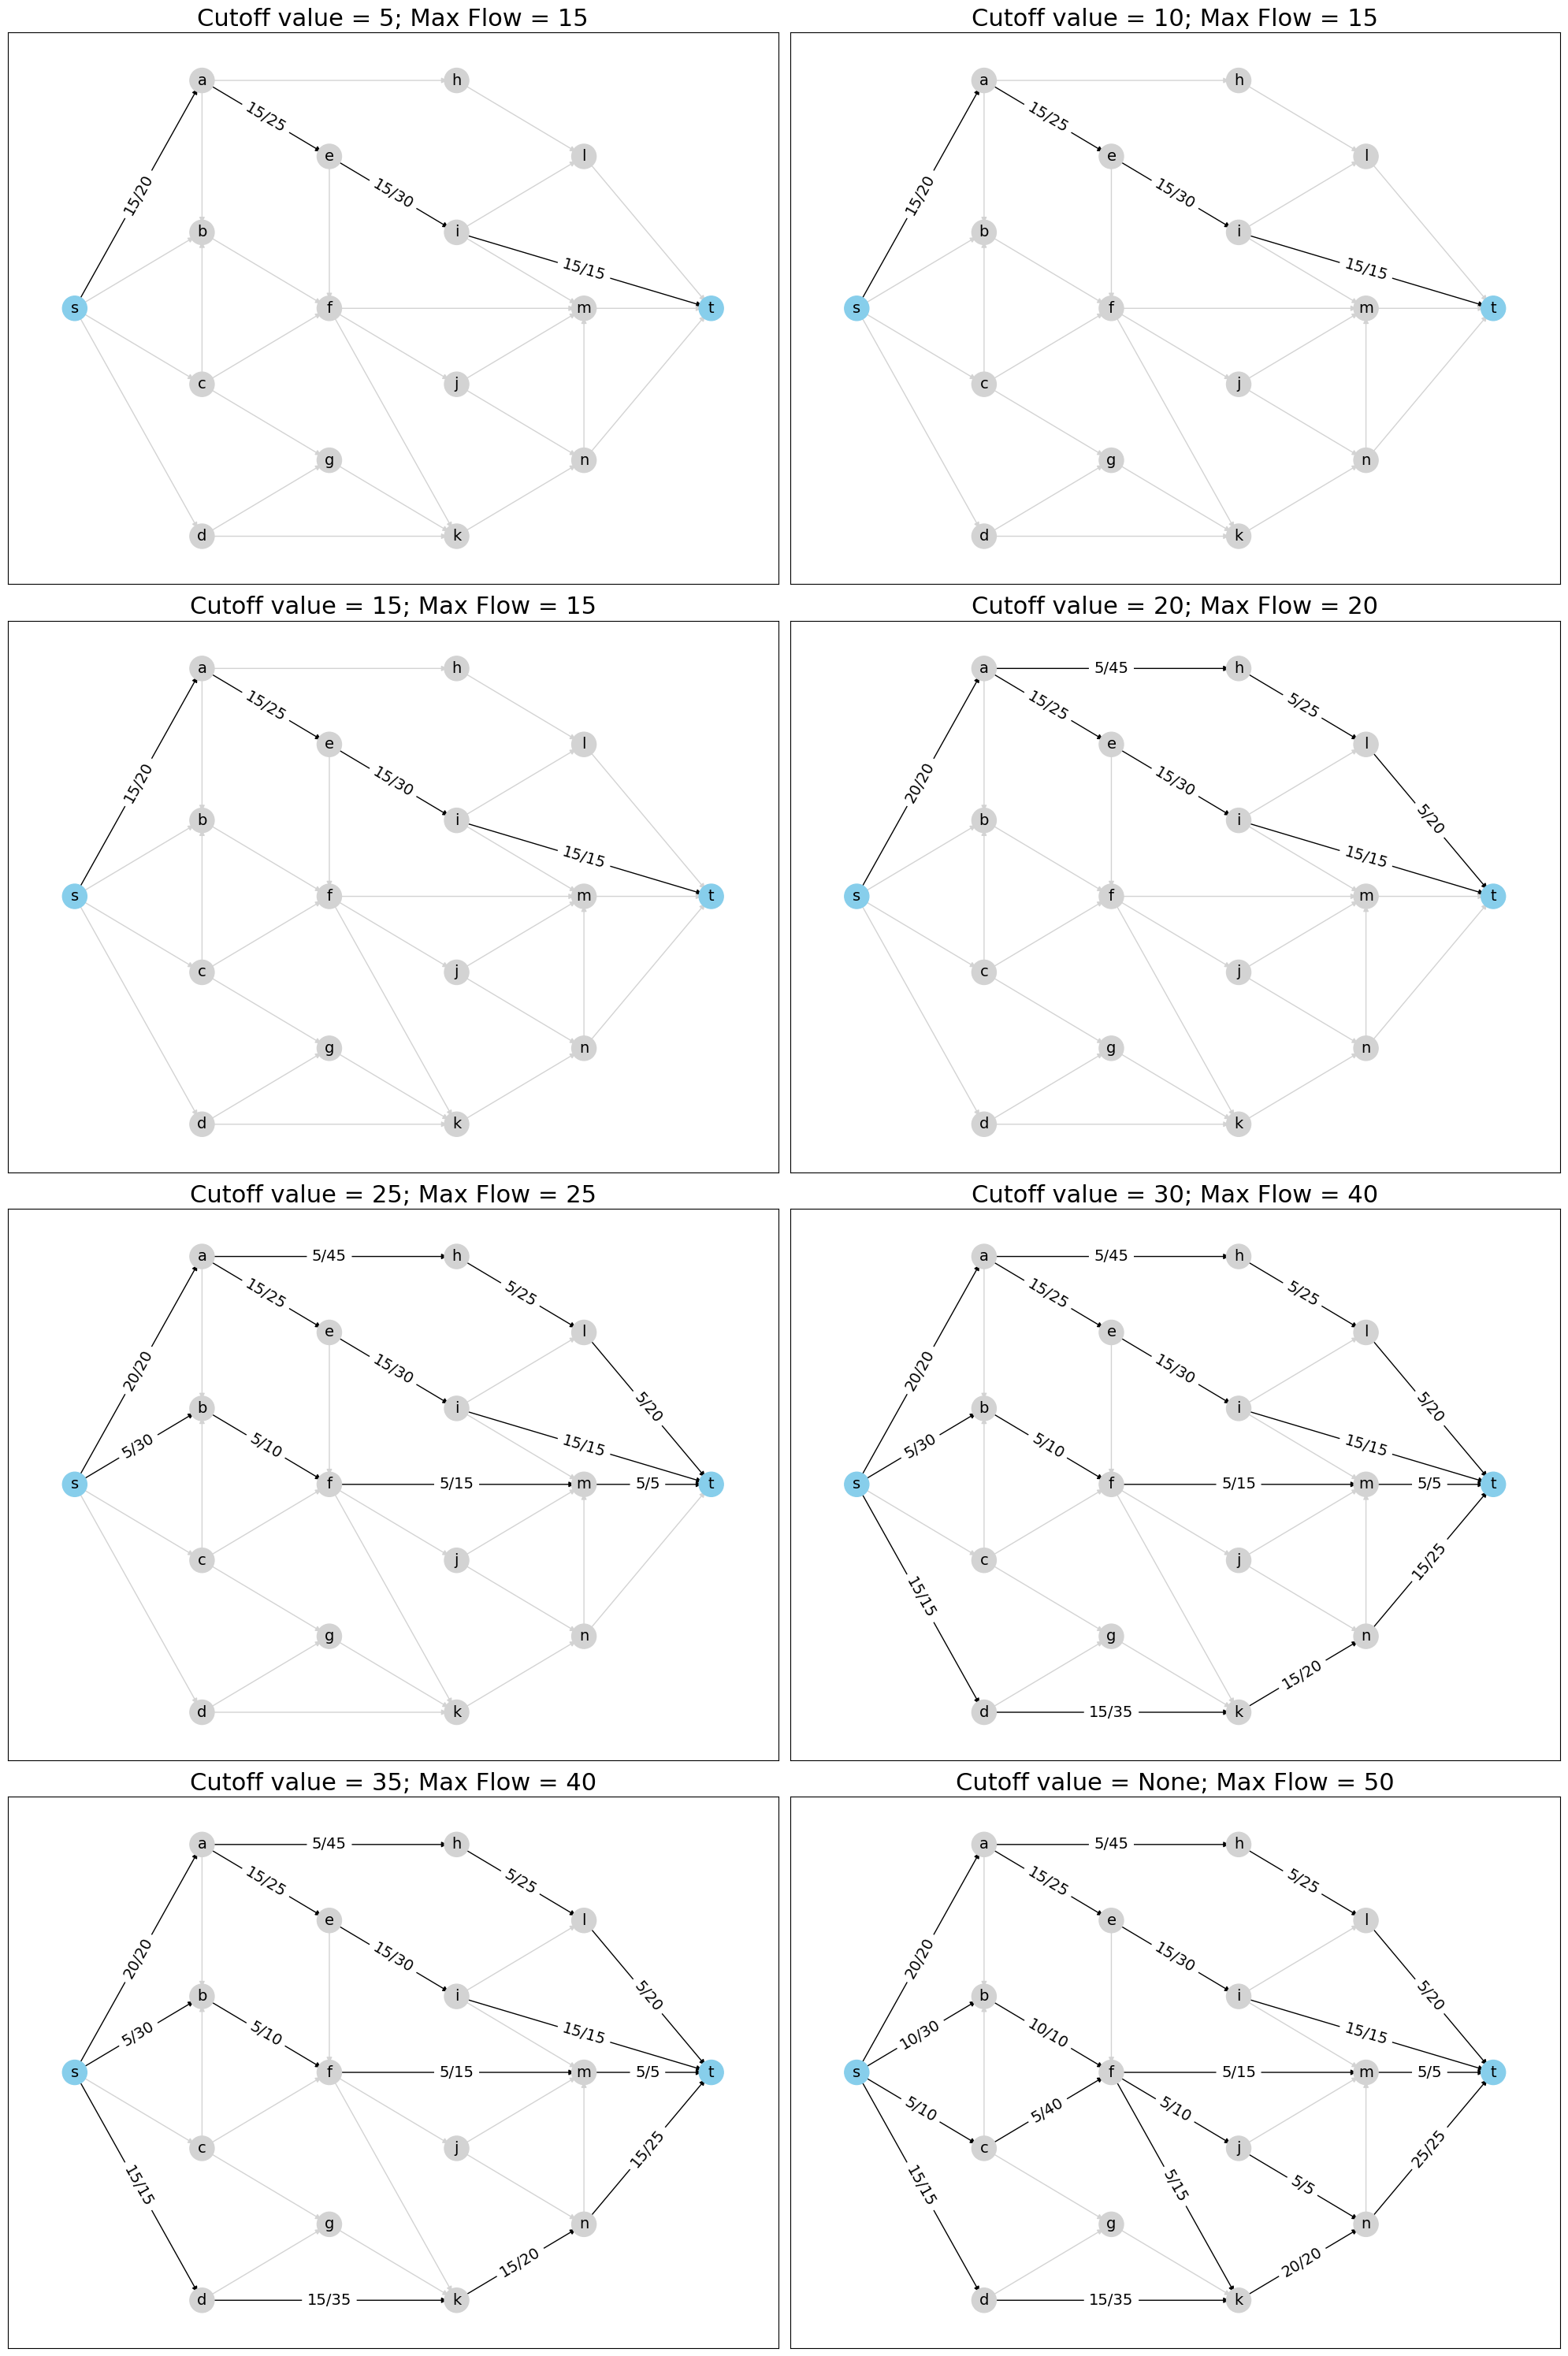

In [19]:
# 要寻找的最大流值。注意最后的 `None` 值，表示算法应运行至完成，找到真正的最大流
cutoff_list = [5, 10, 15, 20, 25, 30, 35, None]

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in G.nodes]

for cutoff, ax in zip(cutoff_list, axes.ravel()):
    # 使用 cutoff 值计算最大流
    R = nx.flow.dinitz(G, s="s", t="t", capacity="capacity", cutoff=cutoff)

    # 根据边是否有非零流值来着色和标记边
    edge_colors = ["lightgray" if R[u][v]["flow"] == 0 else "black" for u, v in G.edges]
    edge_labels = {
        (u, v): f"{R[u][v]['flow']}/{G[u][v]['capacity']}"
        for u, v in G.edges
        if R[u][v]["flow"] != 0
    }

    # 绘制网络
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=500, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, ax=ax, font_size=14)
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=edge_colors)
    nx.draw_networkx_edge_labels(
        G, pos=pos, ax=ax, edge_labels=edge_labels, font_size=14
    )
    ax.set_title(
        f"Cutoff value = {cutoff}; Max Flow = {R.graph['flow_value']}",
        size=22,
    )

fig.tight_layout()

注意：如果找到的最大流已超过 cutoff 值，则停止迭代。

## 应用
还有许多其他问题可以简化为最大流问题，例如：
* [最大二分匹配](https://en.wikipedia.org/wiki/Matching_(graph_theory))
* [分配问题](https://en.wikipedia.org/wiki/Assignment_problem)
* [运输问题](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics))

以及其他许多问题。

需要注意的是，尽管 Dinitz 算法在 $O(n^2m)$ 强多项式时间内运行，即它不依赖于流值。值得注意的是，它在二分图上的性能特别快，为 $O(\sqrt n m)$ 时间，其中 $n = |V|$ 和 $m = |E|$。

让我们考虑一个从仓库通过一些中间运输点向客户运送包裹的例子，并且我们每天只能通过一个中间运输点运送有限数量的包裹。

那么如何分配中间运输点给客户，以便每天运送最多的包裹呢？

![image:shipping problem eg](images/shipping-problem.png)

每个中间运输点下方的数字表示它每天可以运送的最大数量，如果边连接了一个中间运输点和客户，那么我们可以从该运输点向该客户发送包裹。

注意，仓库节点命名为 $W$，中间运输点为 $lw1, lw2, lw3$，客户为 $c1,c2...c20$。

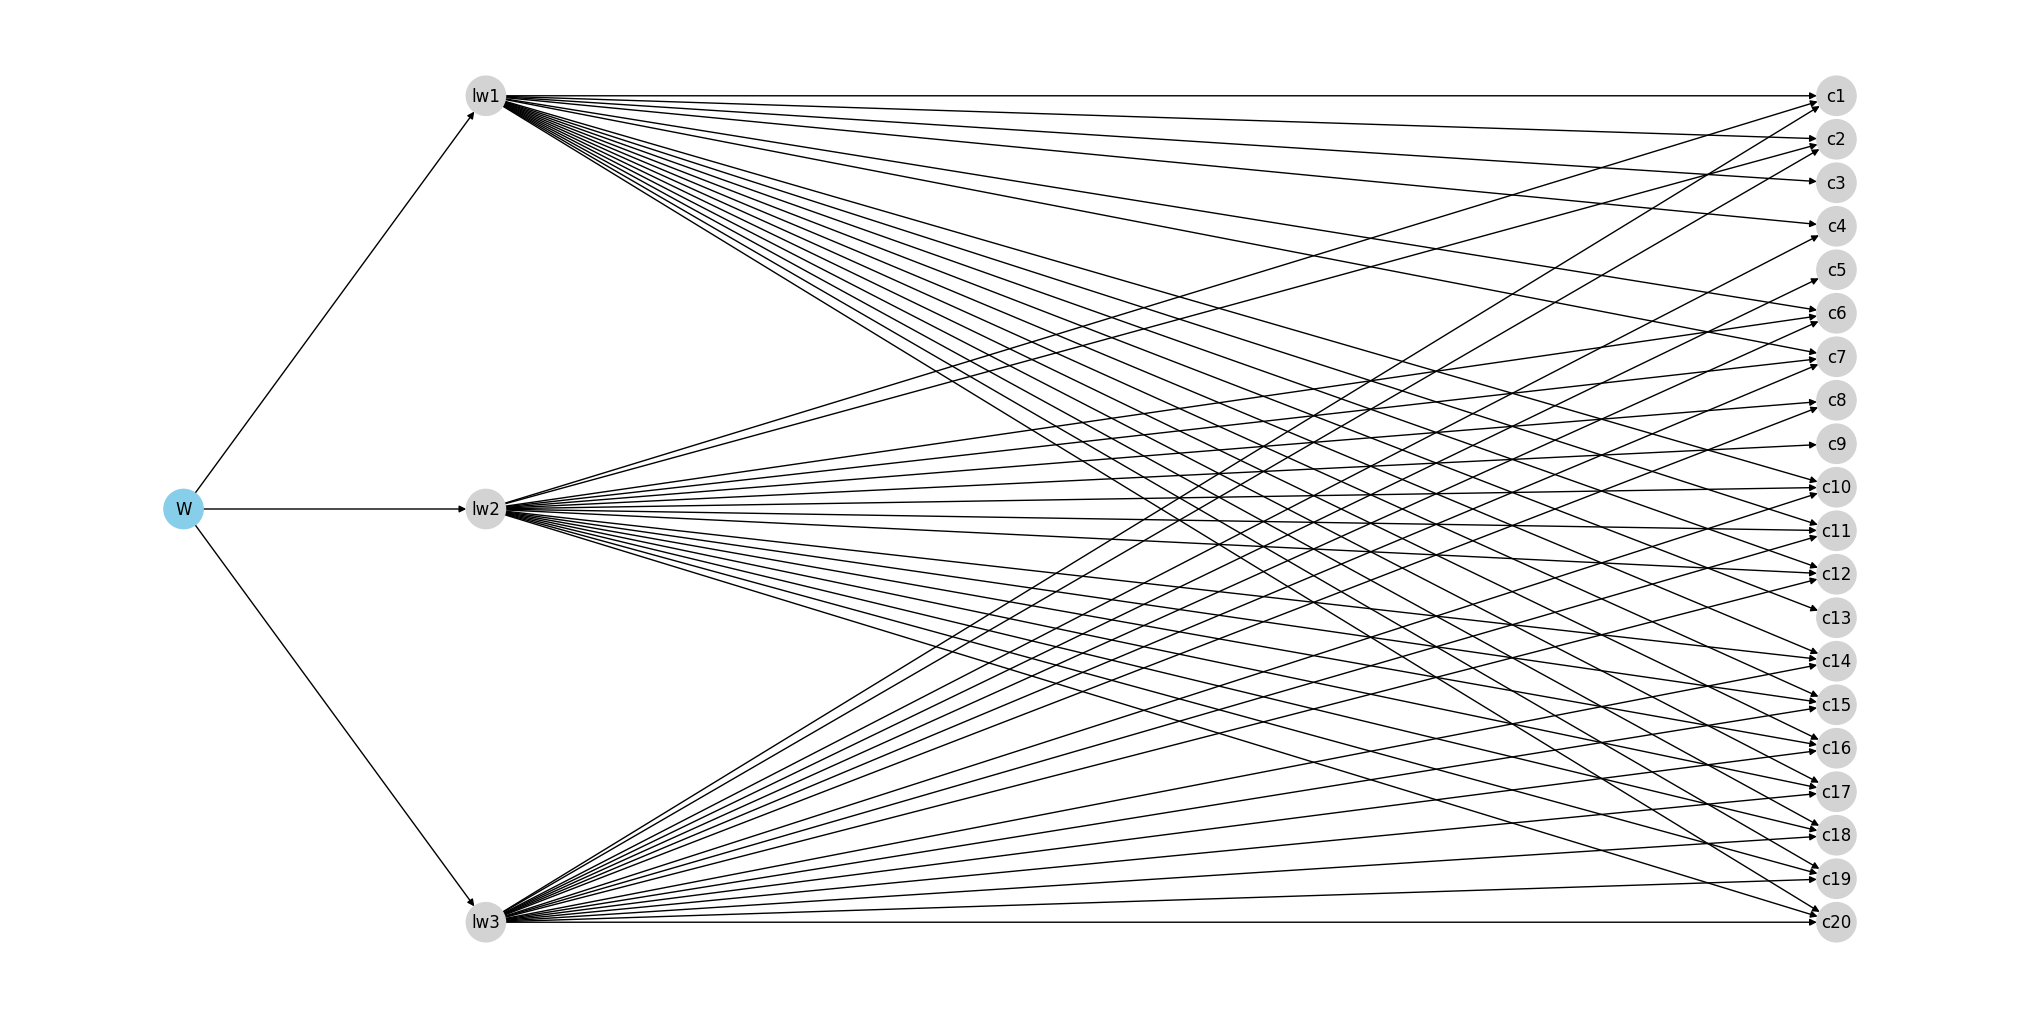

In [20]:
# 加载数据
B = nx.read_gml("data/shipping_graph.gml")
pos = {k: np.asarray(v) for k, v in B.nodes(data="pos")}

# 绘制加载的图
node_colors = ["skyblue" if u == "W" else "lightgray" for u in B.nodes]
plt.figure(figsize=(20, 10))
nx.draw(
    B, pos=pos, node_color=node_colors, with_labels=True, arrowsize=10, node_size=800
)

In [21]:
# 最大运输容量
{u: B.nodes[u]["maximum_shippings"] for u in ["lw1", "lw2", "lw3"]}

{'lw1': 8, 'lw2': 5, 'lw3': 6}

让我们添加一个表示最终汇点的伪节点 $T$，并从
$ci \to T$，$i\in\{1,2,...,20\}$。需要注意的是，超过任何一天 $lwi$（$i\in\{1,2,3\}$）能运送的最大包裹数量都是无用的。因此，我们可以将这一最大运送数量转移到边 $W\to lwi$（$i\in\{1,2,3\}$）的最大容量上，而对于所有其他边，我们可以将其容量设为 1，因为我们每个客户只需要一次运送。

注意：我们已经在前面的步骤中为节点 $T$ 分配了位置，该位置已加载到 `pos` 中。

In [22]:
# 添加节点 T 以及从 c1, c2, ..., c20 到 T 的边
B.add_node("T")
pos["T"] = np.array([0.97, 0.0])
B.add_edges_from((f"c{i}", "T") for i in range(1, 21))

# 添加从 W 到 lw1, lw2, lw3 的容量
for u in ["lw1", "lw2", "lw3"]:
    B["W"][u]["capacity"] = B.nodes[u]["maximum_shippings"]

# 为所有其他边（除从 W 出发的边）添加容量为 1
for u, v in B.edges:
    if u != "W":
        B[u][v]["capacity"] = 1

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


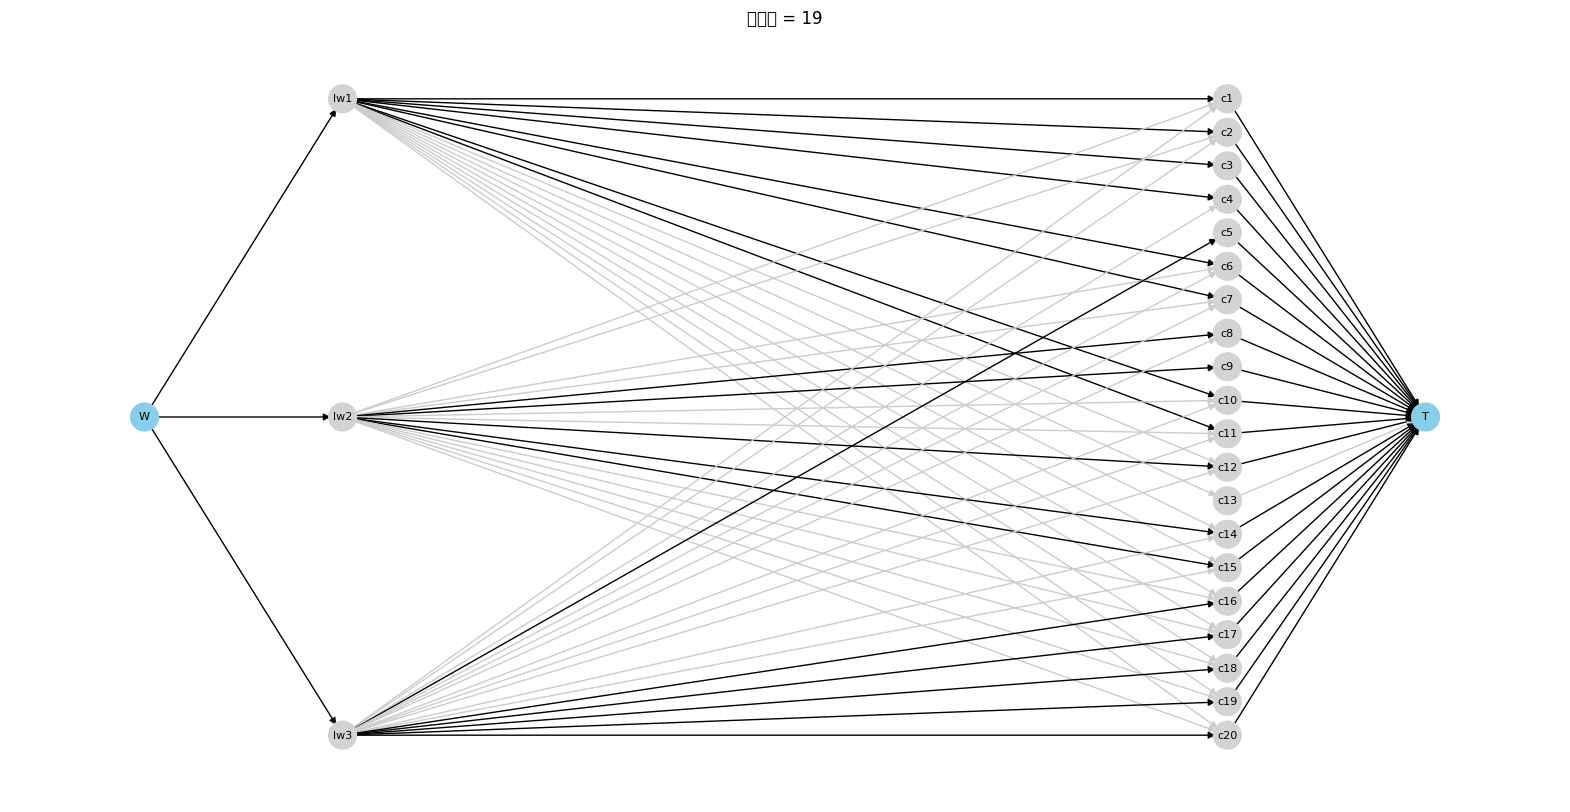

In [23]:
# 根据节点类型为其分配颜色和标签
node_colors = ["skyblue" if u in {"W", "T"} else "lightgray" for u in B.nodes]

# 计算最大流，使用截止值
R = nx.flow.dinitz(B, s="W", t="T", capacity="capacity")

# 根据边的流量值是否为零来为其着色和标记
edge_colors = ["0.8" if R[u][v]["flow"] == 0 else "0" for u, v in B.edges]

# 绘制网络
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(B, pos=pos, node_size=400, node_color=node_colors)
nx.draw_networkx_labels(B, pos=pos, font_size=8)
nx.draw_networkx_edges(B, pos=pos, edge_color=edge_colors)
plt.title(f"最大流 = {R.graph['flow_value']}", size=12)
plt.axis("off")
plt.show()

上述结果展示了一天中中间运输点和客户之间的匹配，这种匹配实现了最大运送量。

## 参考文献
[^1]: [Wikipedia, 最大流问题](https://en.wikipedia.org/wiki/Maximum_flow_problem)

[^2]: Dinitz 算法：原始版本与 Even 版本。2006 年。Yefim Dinitz。理论计算机科学讲座笔记。第 3895 卷。第 218-240 页。<https://doi.org/10.1007/11685654_10>